# Problem Statement

There are many definitions for heatwaves. Generally they are series of days or nights with temperature above average or a threshold. Although there are many investigation on impact of heatwaves on health, water and energy consumption, agricultural activities, wildfire, there are only a few studies on the impact of heatwaves on crimes. There are reports connecting the higher temperature to higher crime rate.For example:

https://www.foxweather.com/lifestyle/summer-crime-wave

https://www.bbc.com/future/article/20200817-the-sinister-ways-heatwaves-warp-the-mind

https://www.washingtonpost.com/business/2019/07/16/two-new-studies-warn-that-hotter-world-will-be-more-violent-one/

https://www.wsj.com/articles/los-angeles-heat-wave-could-lead-to-crime-wave-in-poor-neighborhoods-study-says-11561392032

https://www.theguardian.com/news/2019/aug/02/weatherwatch-a-heatwave-can-lead-to-a-crime-wave

Here, we investigate the crime rate in chicago over the last 20 years. We want to see if there is any connection between high daytime or night time temperature and crime rate. Also we want to know what type of crimes (as defined by Chicago Police) are more impacted by higher temprature.
We obtained the data for this study from the following two main sources:

Crime rate date:

https://data.cityofchicago.org/Public-Safety/Crimes-2001-to-present-Dashboard/5cd6-ry5g

Temperature data:

https://www.ncei.noaa.gov/cdo-web/search

*Important disclosure: In this study, the population of City has increased about 5% over the time of the study. We didn't normalized the data per population. One reason is the reliable data are released every 10 years and the focus of this study is on daily data.

# Historical Trend

In [1]:
#Installing required Libraries for this study (If they haven't been installed/updated already):

#! pip install missingno
#! pip install folium
#! pip install prophet
# TF update, See "https://developers.google.com/protocol-buffers/docs/news/2022-05-06#python-updates"
# !pip install protobuf==3.20.*

# Importing  required libraries

In [1]:
#Data manipulation and visualization:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('whitegrid')
import folium
import folium.plugins as fol_plugins
from datetime import datetime
import statsmodels.api as sm
from prophet import Prophet
from pandas.tseries.holiday import USFederalHolidayCalendar
import timeit


#Other
import warnings
warnings.filterwarnings("ignore")
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:
#The data is dowloaded as csv. It is about 1.9 GB. I load the data once and then by extracting and saving the required
# data for future use, will create lighter version of data.

df_all = pd.read_csv('Crimes_-_2001_to_Present.csv')

In [3]:
df_all.head()

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Longitude,Location,Historical Wards 2003-2015,Zip Codes,Community Areas,Census Tracts,Wards,Boundaries - ZIP Codes,Police Districts,Police Beats
0,10224738,HY411648,09/05/2015 01:30:00 PM,043XX S WOOD ST,0486,BATTERY,DOMESTIC BATTERY SIMPLE,RESIDENCE,False,True,...,-87.670000,"(41.815117282, -87.669999562)",29.0,14924.0,59.0,706.0,3.0,37.0,23.0,108.0
1,10224739,HY411615,09/04/2015 11:30:00 AM,008XX N CENTRAL AVE,0870,THEFT,POCKET-PICKING,CTA BUS,False,False,...,-87.765400,"(41.895080471, -87.765400451)",4.0,4299.0,26.0,562.0,45.0,5.0,25.0,67.0
2,11646166,JC213529,09/01/2018 12:01:00 AM,082XX S INGLESIDE AVE,0810,THEFT,OVER $500,RESIDENCE,False,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10224740,HY411595,09/05/2015 12:45:00 PM,035XX W BARRY AVE,2023,NARCOTICS,POSS: HEROIN(BRN/TAN),SIDEWALK,True,False,...,-87.716650,"(41.937405765, -87.716649687)",15.0,21538.0,22.0,216.0,12.0,39.0,7.0,168.0
4,10224741,HY411610,09/05/2015 01:00:00 PM,0000X N LARAMIE AVE,0560,ASSAULT,SIMPLE,APARTMENT,False,True,...,-87.755121,"(41.881903443, -87.755121152)",11.0,22216.0,26.0,696.0,23.0,32.0,25.0,81.0


In [4]:
for column in df_all.columns:
    temp = df_all[column].nunique()
    print(f'{column}: {temp} unique entries')

ID: 7643707 unique entries
Case Number: 7643185 unique entries
Date: 3142633 unique entries
Block: 62396 unique entries
IUCR: 403 unique entries
Primary Type: 36 unique entries
Description: 542 unique entries
Location Description: 215 unique entries
Arrest: 2 unique entries
Domestic: 2 unique entries
Beat: 304 unique entries
District: 24 unique entries
Ward: 50 unique entries
Community Area: 78 unique entries
FBI Code: 26 unique entries
X Coordinate: 78880 unique entries
Y Coordinate: 130073 unique entries
Year: 22 unique entries
Updated On: 5168 unique entries
Latitude: 880543 unique entries
Longitude: 879962 unique entries
Location: 881769 unique entries
Historical Wards 2003-2015: 53 unique entries
Zip Codes: 83 unique entries
Community Areas: 77 unique entries
Census Tracts: 801 unique entries
Wards: 50 unique entries
Boundaries - ZIP Codes: 61 unique entries
Police Districts: 25 unique entries
Police Beats: 277 unique entries


In [5]:
# Checking for possible duplication and removing them if needed.
df_all[df_all.drop(columns=['ID']).duplicated(keep=False)].head()

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Longitude,Location,Historical Wards 2003-2015,Zip Codes,Community Areas,Census Tracts,Wards,Boundaries - ZIP Codes,Police Districts,Police Beats
6493827,9534766,HX188735,03/17/2014 08:00:00 PM,001XX E ONTARIO ST,1505,PROSTITUTION,CALL OPERATION,HOTEL/MOTEL,True,False,...,-87.623478,"(41.893346855, -87.623478469)",22.0,21182.0,37.0,159.0,36.0,6.0,14.0,74.0
6495844,9538562,HX188735,03/17/2014 08:00:00 PM,001XX E ONTARIO ST,1505,PROSTITUTION,CALL OPERATION,HOTEL/MOTEL,True,False,...,-87.623478,"(41.893346855, -87.623478469)",22.0,21182.0,37.0,159.0,36.0,6.0,14.0,74.0
7196244,1208,G678817,11/11/2001 02:52:00 AM,039XX W LAWRENCE AVE,0110,HOMICIDE,FIRST DEGREE MURDER,APARTMENT,False,False,...,-87.727204,"(41.968249306, -87.727203575)",28.0,21849.0,14.0,117.0,12.0,20.0,1.0,9.0
7196246,1207,G678817,11/11/2001 02:52:00 AM,039XX W LAWRENCE AVE,0110,HOMICIDE,FIRST DEGREE MURDER,APARTMENT,False,False,...,-87.727204,"(41.968249306, -87.727203575)",28.0,21849.0,14.0,117.0,12.0,20.0,1.0,9.0
7301442,26687,JF198311,04/05/2022 03:45:00 PM,113XX S GREEN ST,0110,HOMICIDE,FIRST DEGREE MURDER,HOUSE,False,False,...,-87.643459,"(41.688105474, -87.643459236)",45.0,22212.0,74.0,663.0,22.0,13.0,9.0,263.0


In [6]:
#Removing duplicated values 
# There are some duplicated date, with difference in ID only. I am removing them in this step
# Adding ~ simply means these are not duplicated

df_all = df_all[~df_all.drop(columns=['ID']).duplicated()]

In [7]:
#There is no more duplication!
df_all[df_all.drop(columns=['ID']).duplicated(keep=False)].head()

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Longitude,Location,Historical Wards 2003-2015,Zip Codes,Community Areas,Census Tracts,Wards,Boundaries - ZIP Codes,Police Districts,Police Beats


In [8]:
#Checking for missing values
df_all.isna().sum()

ID                                 0
Case Number                        4
Date                               0
Block                              0
IUCR                               0
Primary Type                       0
Description                        0
Location Description            9635
Arrest                             0
Domestic                           0
Beat                               0
District                          47
Ward                          614843
Community Area                613474
FBI Code                           0
X Coordinate                  251243
Y Coordinate                  251243
Year                               0
Updated On                         0
Latitude                      251243
Longitude                     251243
Location                      251243
Historical Wards 2003-2015    272823
Zip Codes                     251243
Community Areas               269889
Census Tracts                 267794
Wards                         269775
B

In [10]:
#There are different missing values in categories. In the first step, we want to see the historical trend in various
# crime types. Accordingly, the ID, Date, and Primary Type are the most important columns in this dataset.
df_main = df_all[["ID","Date", "Primary Type"]]

In [11]:
df_main.isna().sum()

ID              0
Date            0
Primary Type    0
dtype: int64

In [12]:
df_main.head()

,ID,Date,Primary Type
0,10224738,09/05/2015 01:30:00 PM,BATTERY
1,10224739,09/04/2015 11:30:00 AM,THEFT
2,11646166,09/01/2018 12:01:00 AM,THEFT
3,10224740,09/05/2015 12:45:00 PM,NARCOTICS
4,10224741,09/05/2015 01:00:00 PM,ASSAULT


In [13]:
df_main["Primary Type"].unique()

array(['BATTERY', 'THEFT', 'NARCOTICS', 'ASSAULT', 'BURGLARY', 'ROBBERY',
       'DECEPTIVE PRACTICE', 'OTHER OFFENSE', 'CRIMINAL DAMAGE',
       'WEAPONS VIOLATION', 'CRIMINAL TRESPASS', 'MOTOR VEHICLE THEFT',
       'SEX OFFENSE', 'INTERFERENCE WITH PUBLIC OFFICER',
       'OFFENSE INVOLVING CHILDREN', 'PUBLIC PEACE VIOLATION',
       'PROSTITUTION', 'GAMBLING', 'CRIM SEXUAL ASSAULT',
       'LIQUOR LAW VIOLATION', 'CRIMINAL SEXUAL ASSAULT', 'ARSON',
       'STALKING', 'KIDNAPPING', 'INTIMIDATION',
       'CONCEALED CARRY LICENSE VIOLATION', 'NON - CRIMINAL',
       'HUMAN TRAFFICKING', 'OBSCENITY', 'PUBLIC INDECENCY',
       'OTHER NARCOTIC VIOLATION', 'NON-CRIMINAL', 'HOMICIDE',
       'NON-CRIMINAL (SUBJECT SPECIFIED)', 'RITUALISM',
       'DOMESTIC VIOLENCE'], dtype=object)

In [37]:
#Saving this dataset for the future
#df_main.to_csv("df_main.csv", index=False)
df_main = pd.read_csv('df_main.csv')

In [38]:
#As we are interested in the impact of temperature on crime rate, and we want to see a full cycle of temperature change
# over a year, I am going to remove the data for first nine months on 2022.

df_main = df_main[(df_main["Date"] <"2022-01-01")]


In [39]:
df_main.sort_values(["Date"])

,ID,Date,Primary Type
1047061,1311049,01/01/2001 01:00:00 AM,CRIMINAL DAMAGE
1047269,1311626,01/01/2001 01:00:00 AM,CRIMINAL DAMAGE
1047584,1312658,01/01/2001 01:00:00 AM,BATTERY
1057464,1330412,01/01/2001 01:00:00 AM,THEFT
1046942,1310586,01/01/2001 01:00:00 AM,THEFT
...,...,...,...
7277535,12581450,12/31/2021 12:45:00 PM,CONCEALED CARRY LICENSE VIOLATION
7297038,12581388,12/31/2021 12:45:00 PM,ASSAULT
7274452,12581977,12/31/2021 12:46:00 PM,ASSAULT
7282724,12582396,12/31/2021 12:49:00 AM,DECEPTIVE PRACTICE


# Visualization 

In [44]:
# converting Date data to date and time.
# This takes a few minutes...
df_main['Date'] = pd.to_datetime(df_main['Date'])

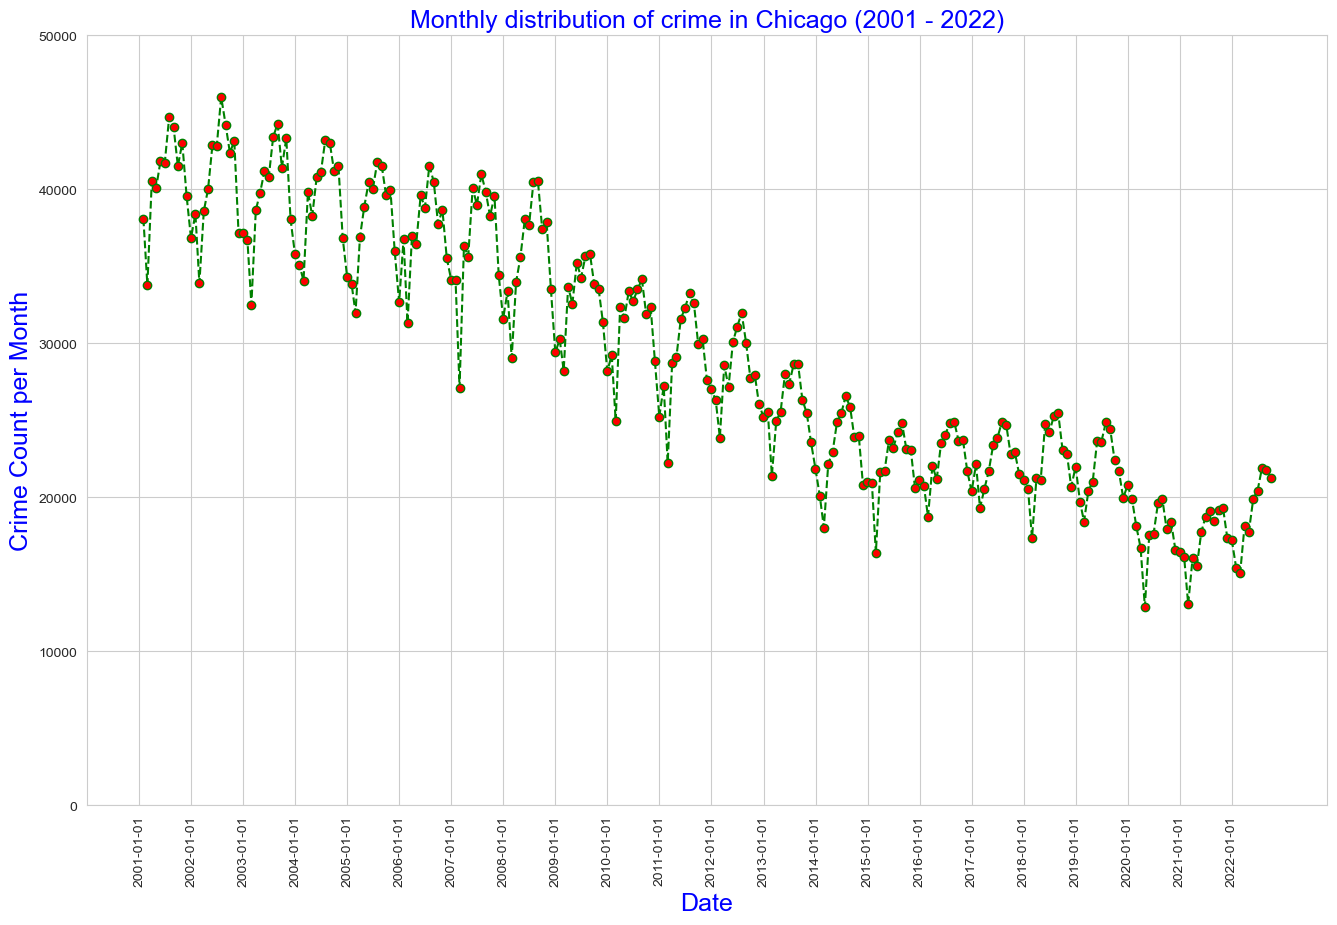

In [18]:
count = df_main.set_index('Date').resample('M')['ID'].count()
fig, ax = plt.subplots(figsize = (16,10))
ax.plot(count,color='green',linestyle='dashed', marker='o', markerfacecolor='red', markersize=6)

dates=[]
for i in np.arange(2001, 2023):
    dates.append(f'{i}-01-01')
ax.set_xticks(dates)
ax.set_ylim([0,50000])
ax.set_xlabel('Date', fontsize=18,color ='blue')
ax.set_ylabel('Crime Count per Month', fontsize=18,color ='blue')
ax.set_title('Monthly distribution of crime in Chicago (2001 - 2022)', fontsize=18 ,color ='blue')
plt.xticks(rotation=90)
plt.show()

In [8]:
# Looks like the number of crimes are going down :)
# Now, we want to see if this applies to all crimes or there is specific sort of crimes that were infact increasing.
#First, let see what are the major type of crimes by a barplot.
#We have 36 type of crimes in total

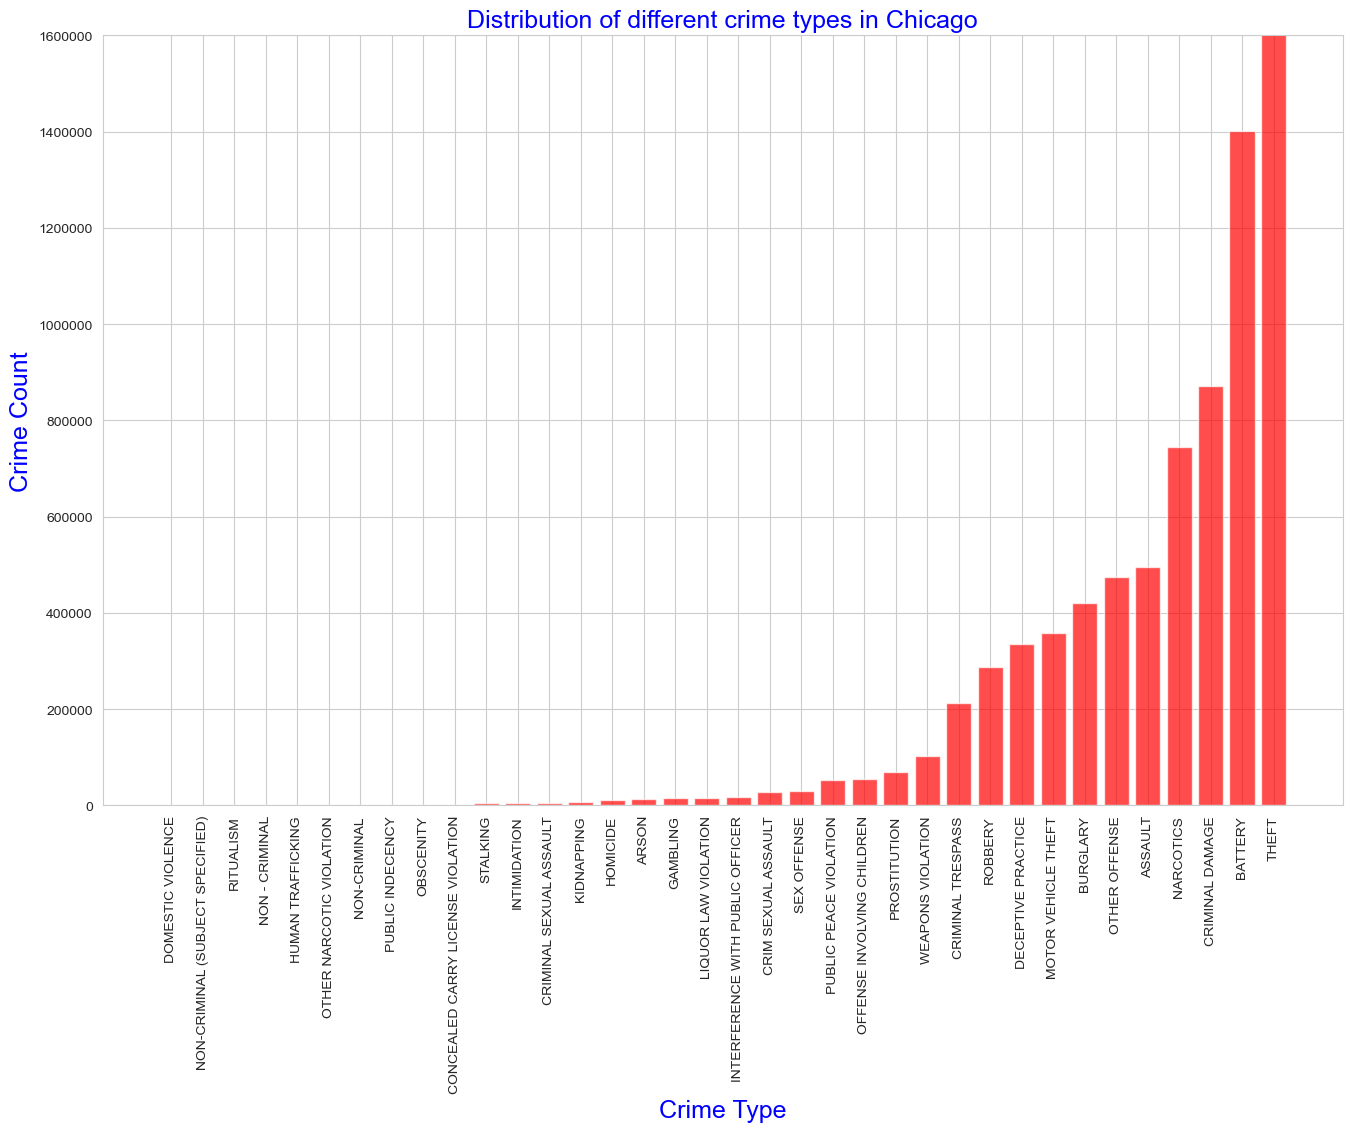

In [19]:
temp = df_main.groupby('Primary Type')['ID'].count().sort_values()

fig, ax = plt.subplots(figsize=(16,10))

ax.bar(temp.index, temp, color='red', alpha=0.7)

plt.ticklabel_format(style='plain', axis='y')

ax.set_xlabel('Crime Type', fontsize=18,color ='blue')
ax.set_ylabel('Crime Count', fontsize=18,color ='blue')
ax.set_title('Distribution of different crime types in Chicago', fontsize=18 ,color ='b')

ax.set_ylim([0,1600000])
plt.xticks(rotation=90)
plt.show()

In [20]:
# We downloaded the location of police districts, and the following shows the distribution of crimes across the city.
# This is NOT distribution of crimes, but it shows the police districts that have handeled these cases.

dftemp = pd.read_csv('Police_Stations_-_Map.csv')
dftemp2 = dftemp[dftemp['DISTRICT'] != 'Headquarters']
dftemp2['DISTRICT'] = dftemp2['DISTRICT'].astype(int)
dftemp2 = dftemp2.sort_values('DISTRICT')

# Here, we are using the main data set (which includes District). You can also, add this column to daily main.
a = df_all.groupby('District')['ID'].count().drop([21, 31])
b = dftemp2[['LATITUDE','LONGITUDE']].reset_index(drop=True)
c = b.merge(pd.DataFrame(a),left_index=True,right_index=True)

In [21]:
folium_map = folium.Map(location=[41.8781, -87.6298],
                        zoom_start=10)
folium.TileLayer('stamenterrain').add_to(folium_map)
folium.plugins.HeatMap(c.values.tolist()).add_to(folium.FeatureGroup(name='Heat Map').add_to(folium_map))
folium_map

In [48]:
# For this analysis, we are focusing on date and day and not the time of the crime type. Accordingly, I am transferring 
# all date-time information in Date column to only date
df_main_daily = df_main
df_main_daily['Date'] = pd.to_datetime(df_main_daily['Date']).dt.date

In [49]:
#Now, we are pivoting data to count different type of crimes each day. Also, filling Nan with 0
daily_main = df_main_daily.pivot_table(index='Date', columns='Primary Type', values='ID', aggfunc='count')
daily_main = daily_main.fillna(0)

In [50]:
daily_main

Primary Type,ARSON,ASSAULT,BATTERY,BURGLARY,CONCEALED CARRY LICENSE VIOLATION,CRIM SEXUAL ASSAULT,CRIMINAL DAMAGE,CRIMINAL SEXUAL ASSAULT,CRIMINAL TRESPASS,DECEPTIVE PRACTICE,...,OTHER OFFENSE,PROSTITUTION,PUBLIC INDECENCY,PUBLIC PEACE VIOLATION,RITUALISM,ROBBERY,SEX OFFENSE,STALKING,THEFT,WEAPONS VIOLATION
Date,,,,,,,,,,,,,,,,,,,,,
2001-01-01,0.0,70.0,296.0,66.0,0.0,38.0,233.0,4.0,29.0,93.0,...,167.0,5.0,0.0,5.0,0.0,41.0,65.0,1.0,412.0,32.0
2001-01-02,0.0,66.0,143.0,68.0,0.0,2.0,118.0,0.0,35.0,78.0,...,101.0,11.0,0.0,2.0,0.0,35.0,4.0,0.0,221.0,9.0
2001-01-03,1.0,79.0,165.0,57.0,0.0,7.0,136.0,0.0,35.0,49.0,...,96.0,16.0,0.0,7.0,0.0,51.0,5.0,1.0,226.0,7.0
2001-01-04,1.0,57.0,173.0,55.0,0.0,2.0,133.0,0.0,29.0,42.0,...,96.0,19.0,0.0,3.0,0.0,55.0,1.0,0.0,243.0,9.0
2001-01-05,3.0,68.0,178.0,55.0,0.0,6.0,142.0,0.0,29.0,53.0,...,90.0,16.0,0.0,5.0,0.0,55.0,2.0,0.0,265.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-26,1.0,62.0,100.0,21.0,0.0,0.0,66.0,3.0,12.0,25.0,...,42.0,0.0,0.0,0.0,0.0,16.0,2.0,0.0,183.0,24.0
2022-09-27,1.0,60.0,90.0,13.0,0.0,0.0,68.0,4.0,10.0,31.0,...,37.0,6.0,0.0,1.0,0.0,26.0,2.0,3.0,173.0,29.0
2022-09-28,2.0,59.0,127.0,18.0,0.0,0.0,89.0,2.0,9.0,15.0,...,43.0,7.0,0.0,0.0,0.0,34.0,3.0,0.0,155.0,31.0


In [51]:
#These are top 20 type of crimes:
top_20_types = df_main['Primary Type'].value_counts().index.tolist()[:20]
top_20_types

['THEFT',
 'BATTERY',
 'CRIMINAL DAMAGE',
 'NARCOTICS',
 'ASSAULT',
 'OTHER OFFENSE',
 'BURGLARY',
 'MOTOR VEHICLE THEFT',
 'DECEPTIVE PRACTICE',
 'ROBBERY',
 'CRIMINAL TRESPASS',
 'WEAPONS VIOLATION',
 'PROSTITUTION',
 'OFFENSE INVOLVING CHILDREN',
 'PUBLIC PEACE VIOLATION',
 'SEX OFFENSE',
 'CRIM SEXUAL ASSAULT',
 'INTERFERENCE WITH PUBLIC OFFICER',
 'LIQUOR LAW VIOLATION',
 'GAMBLING']

In [52]:
temp_20

Primary Type,THEFT,BATTERY,CRIMINAL DAMAGE,NARCOTICS,ASSAULT,OTHER OFFENSE,BURGLARY,MOTOR VEHICLE THEFT,DECEPTIVE PRACTICE,ROBBERY,CRIMINAL TRESPASS,WEAPONS VIOLATION,PROSTITUTION,OFFENSE INVOLVING CHILDREN,PUBLIC PEACE VIOLATION,SEX OFFENSE,CRIM SEXUAL ASSAULT,INTERFERENCE WITH PUBLIC OFFICER,LIQUOR LAW VIOLATION,GAMBLING
Date,,,,,,,,,,,,,,,,,,,,
2001-01-01 00:00:00,71.0,1.0,12.0,0.0,2.0,8.0,1.0,0.0,16.0,0.0,0.0,0.0,0.0,30.0,0.0,39.0,12.0,0.0,0.0,0.0
2001-01-01 00:01:00,49.0,1.0,7.0,0.0,0.0,4.0,1.0,4.0,18.0,0.0,0.0,0.0,0.0,36.0,0.0,13.0,9.0,0.0,0.0,0.0
2001-01-01 00:04:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2001-01-01 00:05:00,0.0,2.0,3.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,1.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2001-01-01 00:07:00,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-30 23:50:00,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-09-30 23:52:00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-09-30 23:54:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


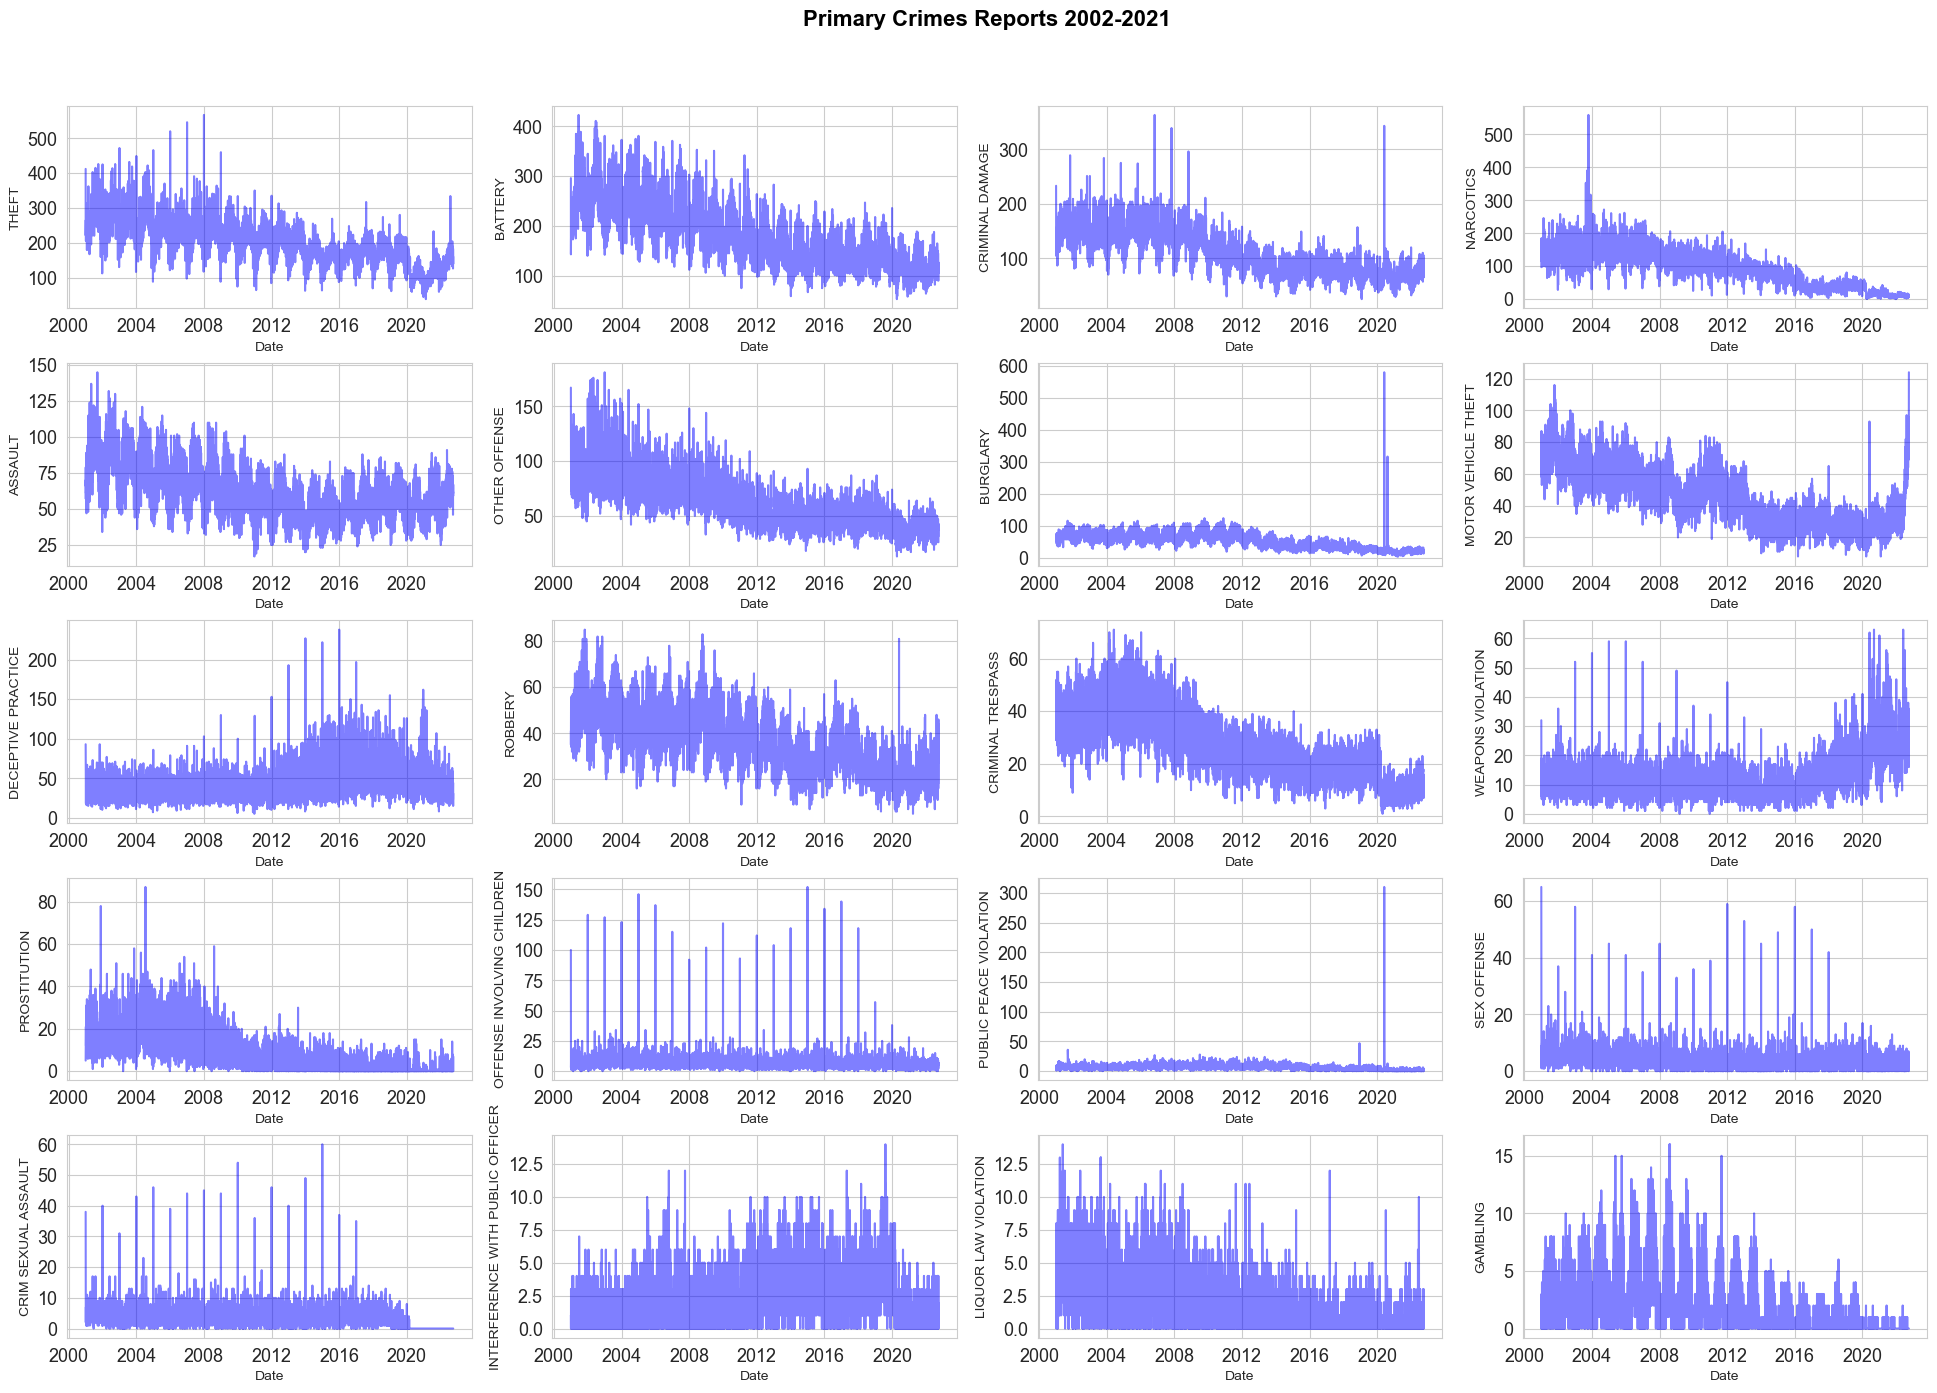

In [53]:
# Figures below show the change of the first 20 types of major crimes over the last 20 years.
temp_20 = daily_main[top_20_types]

fig = plt.figure(figsize=[20,16], facecolor='w')

plt.subplots_adjust(bottom=0.15, top=0.92, left=0.04, right=.97, 
                     wspace=0.2, hspace=0.27)
nrows = 5
ncols = 4

fig.suptitle("Primary Crimes Reports 2002-2021", fontsize=16, y=.98,fontweight = 'bold', color = 'black')

for i in range(1, 21):
    plt.subplot(nrows, ncols, i)
      
    sns.lineplot(x="Date", y=temp_20[temp_20.columns[i-1]], data=temp_20, color = 'b',alpha = .5 )
    
    #Regression line
    #sns.regplot(x=temp_20["THEFT"].index, y=temp_20[temp_20.columns[i-1]],
               #order=5,scatter=False, line_kws={"color": "red"})
    
    
    plt.xticks(fontsize = 13)
    plt.yticks(fontsize = 13)
    
plt.savefig('Primary Crimes Reports 2002-2021.png', format = 'png', dpi = 400)      
